In [1]:
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import torch
import copy
import pandas as pd

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate

from gsnn.models.GSNN import GSNN

from sklearn.metrics import r2_score

from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

from gsnn.optim.OutputEdgeInferer import OutputEdgeInferrer

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

# Inferring output edges 



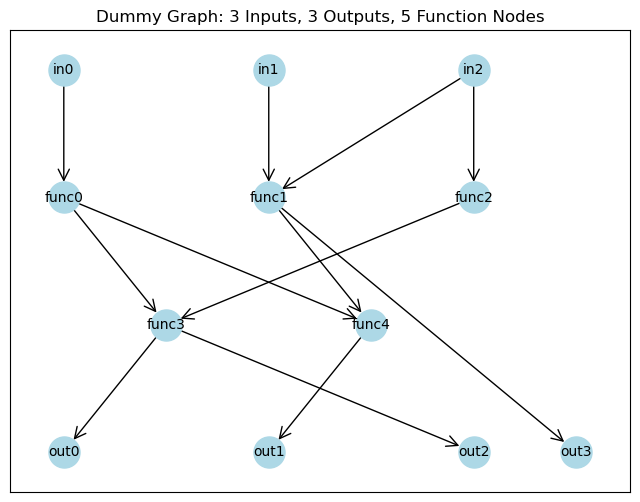

In [2]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2', 'out3']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2'), ('in2', 'func1')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3'), ('func0', 'func4')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2'), ('func1', 'out3')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1), 
    'out3': (3, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:

special_functions = None

x_train, x_test, y_train, y_test = simulate(G, n_train=100, n_test=100, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions, noise_scale=0.15)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)

y_train = (y_train - y_mu)/(y_std + 1e-8)
y_test = (y_test - y_mu)/(y_std + 1e-8)


In [4]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

# simulate a missing edge (in2, func1)
edge_index_dict_TRUE = copy.deepcopy(data.edge_index_dict)


# remove edges func1 to out3
#remove = ('func1', 'out3')
remove = [('func4', 'out1'), ('func3', 'out2'), ('func1', 'out3')]
for edge in remove:
    src, dst = data.edge_index_dict['function', 'to', 'output'].clone()
    mask = ~((src == data.node_names_dict['function'].index(edge[0])) & (dst == data.node_names_dict['output'].index(edge[1])))
    data.edge_index_dict['function', 'to', 'output'] = data.edge_index_dict['function', 'to', 'output'][:, mask]

data.edge_index_dict['function', 'to', 'output']

tensor([[3],
        [0]])

In [5]:
model_kwargs = {'channels': 3, 
                'layers': 5, 
                'share_layers': False, 
                'bias': True, 
                'add_function_self_edges': True, 
                'norm': 'layer', 
                'dropout': 0.,
                'nonlin': torch.nn.ELU}

In [6]:
# train GSNN with a missing input edge  

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             **model_kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

model = model.eval() 
with torch.inference_mode():    
    yhat_test = model(x_test)
loss_test = crit(y_test, yhat_test)
r2_test = r2_score(y_test.detach().cpu().numpy(), yhat_test.detach().cpu().numpy())
print(f'test loss: {loss_test.item():.3f} | test r2: {r2_test:.3f}')


n params 6320
test loss: 0.803 | test r2: 0.193


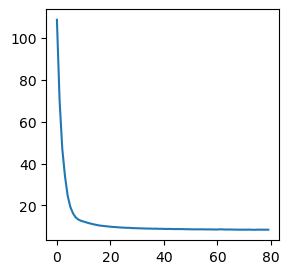

In [32]:
OEI = OutputEdgeInferrer(data, 
                         model.channels*model.layers, 
                         lr=1e-2, 
                         wd=0, 
                         epochs=2000, 
                         use_batchnorm=False,
                         bn_affine=False,
                         tol=1e-4,
                         patience=5,
                         agg='all')

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=10, shuffle=True)
losses = OEI.fit(train_loader, model)

plt.figure(figsize=(3,3))
plt.plot(losses)
plt.show()

In [33]:
res = OEI.eval(test_loader, model.eval())
res.sort_values(by='q_value', ascending=True)

,func_node,output_node,mse,r2,r,has_edge,p_value,model_r2,model_r,model_mse,r2_gain,r_gain,mse_gain,q_value,within_output_rank
0,func1,out3,0.173099,0.835852,0.926410,False,1.620504e-11,0.000000,NaN,1.120165,0.835852,NaN,-0.947066,3.241007e-10,1
1,func3,out2,0.041673,0.955551,0.977525,False,3.024097e-09,0.000000,NaN,0.958269,0.955551,NaN,-0.916597,1.695624e-08,1
2,func4,out2,0.113510,0.879553,0.938532,False,2.505851e-09,0.000000,NaN,0.958269,0.879553,NaN,-0.844760,1.695624e-08,2
3,func4,out1,0.319987,0.698461,0.837344,False,3.391248e-09,0.000000,NaN,1.084873,0.698461,NaN,-0.764886,1.695624e-08,1
4,func1,out1,0.506731,0.526771,0.729640,False,1.093681e-06,0.000000,NaN,1.084873,0.526771,NaN,-0.578142,4.374723e-06,2
5,func3,out1,0.427424,0.594483,0.771336,False,1.523381e-06,0.000000,NaN,1.084873,0.594483,NaN,-0.657449,5.077936e-06,3
6,func0,out1,0.662186,0.352780,0.594718,False,2.229964e-05,0.000000,NaN,1.084873,0.352780,NaN,-0.422687,6.371325e-05,4
7,func4,out3,0.677384,0.366798,0.607753,False,2.928704e-05,0.000000,NaN,1.120165,0.366798,NaN,-0.442781,7.321760e-05,2
8,func0,out2,0.465906,0.504485,0.710914,False,7.773768e-05,0.000000,NaN,0.958269,0.504485,NaN,-0.492364,1.727504e-04,3
9,func1,out2,0.508412,0.476130,0.692864,False,1.118309e-04,0.000000,NaN,0.958269,0.476130,NaN,-0.449858,2.236617e-04,4


In [34]:
res_missing = res[lambda x: (x.within_output_rank == 1) & (x.has_edge == False)]
res_missing_edges = [(i,j) for i,j in res_missing[['func_node', 'output_node']].values]

res_missing_edges

[('func1', 'out3'), ('func3', 'out2'), ('func4', 'out1')]

In [35]:
remove

[('func4', 'out1'), ('func3', 'out2'), ('func1', 'out3')]

In [255]:
res = OEI.eval(x_test, y_test, model)
res

/Users/evansna/miniforge3/envs/gsnn/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/evansna/miniforge3/envs/gsnn/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,func_node,output_node,mse,r2,r,has_edge,model_r2,model_r,model_mse,r2_gain,r_gain,mse_gain
0,func3,out2,0.249225,0.652134,0.822845,False,-0.012447,NaN,0.725357,0.664581,NaN,-0.476132
1,func4,out2,0.413907,0.422272,0.656627,False,-0.012447,NaN,0.725357,0.434720,NaN,-0.311450
2,func1,out2,0.579585,0.191019,0.464892,False,-0.012447,NaN,0.725357,0.203467,NaN,-0.145771
3,func2,out2,0.725357,-0.012447,0.290082,False,-0.012447,NaN,0.725357,0.000000,NaN,0.000000
4,func0,out2,0.725357,-0.012447,-0.108326,False,-0.012447,NaN,0.725357,0.000000,NaN,0.000000
5,func4,out3,0.194236,0.826403,0.908536,False,0.955552,0.977574,0.049732,-0.129150,-0.069038,0.144504
6,func1,out3,0.210476,0.811888,0.902300,True,0.955552,0.977574,0.049732,-0.143664,-0.075274,0.160744
7,func4,out1,0.290861,0.674536,0.822450,True,0.852748,0.923386,0.131596,-0.178212,-0.100936,0.159265
8,func3,out0,0.266247,0.636242,0.815478,True,0.838978,0.915446,0.117857,-0.202736,-0.099968,0.148389
9,func3,out1,0.411345,0.539719,0.731503,False,0.852748,0.923386,0.131596,-0.313030,-0.191884,0.279749


In [68]:
from sklearn.linear_model import LinearRegression

In [148]:
def test_node(model, data, x_train, x_test, y_train, y_test, func_name, output_name): 
    func_idx = data.node_names_dict['function'].index(func_name)
    output_idx = data.node_names_dict['output'].index(output_name)
    
    act_dict_train = model.get_node_activations(x_train, agg='last')
    act_dict_test = model.get_node_activations(x_test, agg='last') 

    a_train = act_dict_train[func_name]
    a_test = act_dict_test[func_name]

    y_train_ = y_train[:, output_idx].detach().cpu().numpy() 
    y_test_ = y_test[:, output_idx].detach().cpu().numpy() 

    lin = LinearRegression()
    lin.fit(a_train, y_train_)

    yhat_test = lin.predict(a_test)

    r2_test = r2_score(y_test_, yhat_test)

    mse_node = np.mean((yhat_test - y_test_)**2)

    # train linear model on all activations to get MI 

    a = np.concatenate([act_dict_train[node] for node in data.node_names_dict['function']], axis=1)

    lin = LinearRegression()
    lin.fit(a, y_train_)

    a_test = np.concatenate([act_dict_test[node] for node in data.node_names_dict['function']], axis=1)
    yhat_test = lin.predict(a_test)

    mse_all = np.mean((yhat_test - y_test_)**2)
    r2_all = r2_score(y_test_, yhat_test)

    mi = 0.5 * np.log(mse_node / mse_all)

    return r2_test, mi

res = {'func_name': [], 'output_name': [], 'r2_test': [], 'mi_test': []}
for func_name in data.node_names_dict['function']: 
        r2_test, mi_test = test_node(model, data, x_train, x_test, y_train, y_test, func_name, 'out3')
        res['func_name'].append(func_name)
        res['output_name'].append('out3')
        res['r2_test'].append(r2_test)
        res['mi_test'].append(mi_test)

res = pd.DataFrame(res)
res.sort_values('r2_test', ascending=False)



,func_name,output_name,r2_test,mi_test
1,func1,out3,0.924049,0.022511
4,func4,out3,0.699929,0.709478
2,func2,out3,0.518821,0.945588
3,func3,out3,0.362968,1.085879
0,func0,out3,-0.035415,1.328748


ValueError: x and y must be the same size

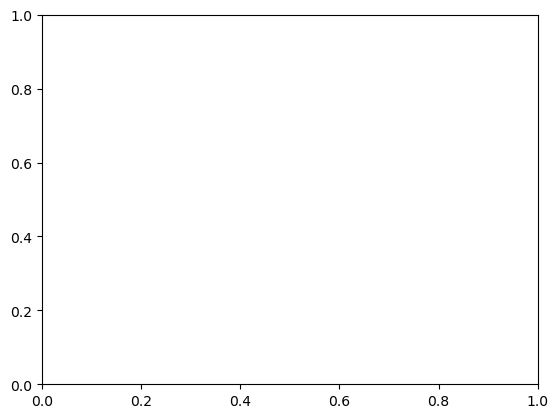

In [73]:
plt.figure() 
plt.scatter(x, y)

In [58]:
torch.distributions.Categorical(logits=torch.tensor(x)) 

Categorical(logits: torch.Size([100, 3]))

# Estimating input errors to infer novel input edges 

1. esimtate error using gradient descent on a trainable input edge parameter 
2. identify correlations between edge errors and input channels 

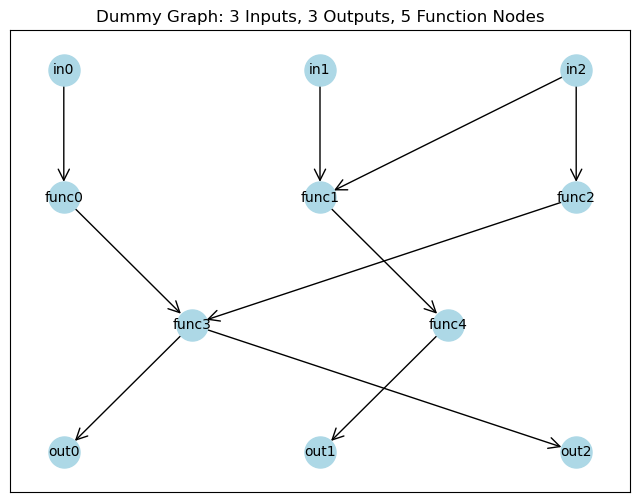

In [2]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2'), ('in2', 'func1')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
special_functions = {'func1': lambda x: -np.mean(x), 'func2':lambda x: np.sum([np.exp(xx) for xx in x]), 
                     'func0': lambda x: np.mean(([(xx-1)**2 for xx in x])), 'func3': lambda x: -np.mean(x) if all([xx > 0 for xx in x]) else np.mean(x)}

special_functions = None

x_train, x_test, y_train, y_test = simulate(G, n_train=25, n_test=100, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions, noise_scale=0.15)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)

y_train = (y_train - y_mu)/(y_std + 1e-8)
y_test = (y_test - y_mu)/(y_std + 1e-8)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

In [4]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

# simulate a missing edge (in2, func1)
edge_index_dict_TRUE = copy.deepcopy(data.edge_index_dict)

edge_index_dict = copy.deepcopy(data.edge_index_dict)

edge_index_dict['input', 'to', 'function'] = edge_index_dict['input', 'to', 'function'][:, :-1] # remove edge from in2 to func1 

data.edge_index_dict = edge_index_dict

In [5]:
model_kwargs = {'channels': 3, 
                'layers': 4, 
                'share_layers': False, 
                'bias': True, 
                'add_function_self_edges': True, 
                'norm': 'none', 
                'dropout': 0.0,
                'nonlin': torch.nn.LeakyReLU}


In [6]:
# train GSNN with a missing input edge  

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             **model_kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

yhat_test = model(x_test)
loss_test = crit(y_test, yhat_test)
r2_test = r2_score(y_test.detach().cpu().numpy(), yhat_test.detach().cpu().numpy())
print(f'test loss: {loss_test.item():.3f} | test r2: {r2_test:.3f}')


n params 381
test loss: 0.217 | test r2: 0.741


In [53]:
# freeze GSNN 
for p in model.parameters(): 
    p.requires_grad = False

# node channels 
nchannels = len(model.indices_params[4])

#node_errs = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros((x_train.size(0), nchannels))) for _ in range(model.layers)])
node_errs = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros((x_train.size(0), nchannels))) for _ in range(1)])

dropout = torch.nn.Dropout(0.)
optim = torch.optim.Adam(node_errs, lr=1e-4, weight_decay=1e-1)
crit = torch.nn.MSELoss()

for i in range(2000): 

    losses = [] 
    for idxs in torch.split(torch.randperm(x_train.size(0)), 100): 
        optim.zero_grad() 

        xx = x_train[idxs]
        yy = y_train[idxs]

        nerrs = [dropout(ne[idxs]) for ne in node_errs] + [None]*(model.layers - 1)

        yhat = model(xx, node_errs=nerrs)
        loss = crit(yy, yhat)
        loss.backward() 
        optim.step()

        losses.append(loss.item())

    print(f'iter: {i} | loss: {np.mean(losses):.3f}',end='\r')

In [54]:
res = {'channel_idx':[], 'function_group':[], 'x_idx':[], 'r':[], 'pval':[]}
for nc, func_idx in zip(range(node_errs[0].size(1)), model.indices_params[4]): 
    channel_err = node_errs[0][:, nc].detach().cpu().numpy()

    for x_idx in range(x_train.size(1)): 
        
        xx = x_train[:, x_idx].detach().cpu().numpy()

        cor = spearmanr(xx, channel_err)

        res['channel_idx'].append(nc)
        res['function_group'].append(func_idx)
        res['x_idx'].append(x_idx)
        res['r'].append(cor.statistic)
        res['pval'].append(cor.pvalue)

res = pd.DataFrame(res)

res = res.assign(func_name = [data.node_names_dict['function'][f] for f in res['function_group']])
res = res.assign(x_name = [data.node_names_dict['input'][f] for f in res['x_idx']])

res = res.assign(pval_adj = multipletests(res['pval'], method='fdr_bh')[1])
res.head()


,channel_idx,function_group,x_idx,r,pval,func_name,x_name,pval_adj
0,0,0,0,0.007692,0.970889,func0,in0,0.997088
1,0,0,1,0.030769,0.883918,func0,in1,0.997088
2,0,0,2,-0.014615,0.944720,func0,in2,0.997088
3,1,0,0,-0.017692,0.933105,func0,in0,0.997088
4,1,0,1,0.361538,0.075771,func0,in1,0.681937


In [55]:
res.sort_values('pval_adj')

,channel_idx,function_group,x_idx,r,pval,func_name,x_name,pval_adj
44,14,4,2,-0.877692,8.324712e-09,func4,in2,3.746120e-07
38,12,4,2,-0.799231,1.655163e-06,func4,in2,3.724117e-05
14,4,1,2,0.694615,1.168413e-04,func1,in2,1.752620e-03
11,3,1,2,-0.429231,3.226016e-02,func1,in2,3.629268e-01
4,1,0,1,0.361538,7.577073e-02,func0,in1,6.819365e-01
26,8,2,2,0.072308,7.312381e-01,func2,in2,9.970883e-01
27,9,3,0,0.050000,8.123860e-01,func3,in0,9.970883e-01
28,9,3,1,0.053077,8.010602e-01,func3,in1,9.970883e-01
29,9,3,2,0.050769,8.095510e-01,func3,in2,9.970883e-01
30,10,3,0,0.047692,8.209046e-01,func3,in0,9.970883e-01
